In [1]:
import os
import time
import copy
import math
import torch
import numpy as np
import torch.nn as nn
import seaborn as sns
import torch.nn.functional as F
from collections import Counter
from langconv import Converter
from nltk import word_tokenize
from torch.autograd import Variable
import matplotlib.pyplot as plt

/data1/ljy/anaconda3/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PAD = 0                             # padding占位符的索引
UNK = 1                             # 未登录词标识符的索引
batch_size = 128                    # 批次大小
epochs = 20                         # 训练轮数
layers = 6                          # transformer中encoder、decoder层数
h_num = 8                           # 多头注意力个数
d_model = 256                       # 输入、输出词向量维数
d_ff = 1024                         # feed forward全连接层维数
dropout = 0.1                       # dropout比例
max_length = 60                     # 语句最大长度

TRAIN_FILE = './en-cn/train.txt'  # 训练集
DEV_FILE = "./en-cn/dev.txt"      # 验证集
save_path = 'save/model.pt'         # 模型保存路径
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
def seq_padding(X, padding=PAD):
    L = max([len(x) for x in X])
    data = np.array([np.concatenate([x, [padding] * (L-len(x))]) if len(x) < L else x for x in X])
    return data

In [4]:
def cht_to_chs(x):
    x = Converter('zh-hans').convert(x)
    x.encode('utf-8')
    return x

In [5]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    # 设定subsequent_mask矩阵的shape
    attn_shape = (1, size, size)
    # 生成一个右上角(不含主对角线)为全1，左下角(含主对角线)为全0的subsequent_mask矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    # 返回一个右上角(不含主对角线)为全False，左下角(含主对角线)为全True的subsequent_mask矩阵
    return torch.from_numpy(subsequent_mask) == 0

class Batch:
    def __init__(self, src, trg=None, pad=PAD):
        src = torch.from_numpy(src).to(device).long()
        trg = torch.from_numpy(trg).to(device).long()
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:,:-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
        
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [6]:
class PrepareData:
    def __init__(self, train_path, dev_path):
        self.train_en, self.train_cn = self.load_data(train_path)
        self.dev_en, self.dev_cn = self.load_data(dev_path)
        
        self.en_word_dict, self.en_total_word, self.en_word_index = self.build_dict(self.train_en)
        self.cn_word_dict, self.cn_total_word, self.cn_word_index = self.build_dict(self.train_cn)

        self.train_en, self.train_cn = self.word2id(self.train_en, self.train_cn, self.en_word_dict, self.cn_word_dict)
        self.dev_en, self.dev_cn = self.word2id(self.dev_en, self.dev_cn, self.en_word_dict, self.cn_word_dict)
        
        self.train_data = self.split_batch(self.train_en, self.train_cn, batch_size)
        self.dev_data = self.split_batch(self.dev_en, self.dev_cn, batch_size)
        
    def load_data(self, path):
        en = []
        cn = []
        with open(path, mode='r', encoding='utf-8') as f:
            for line in f.readlines():
                sent_en, sent_cn = line.strip().split('\t')
                sent_en = sent_en.lower()
                sent_cn = cht_to_chs(sent_cn)
                sent_en = ['BOS'] + word_tokenize(sent_en) + ['EOS']
                sent_cn = ['BOS'] + [char for char in sent_cn] + ['EOS']
                en.append(sent_en)
                cn.append(sent_cn)
        return en, cn
    def build_dict(self, X, max_words=5e4):
        word_count = Counter([word for sent in X for word in sent])
        ls = word_count.most_common(int(max_words))
        total_words = len(ls) + 2
        word_dict = {w[0]:index +2 for index, w in enumerate(ls)}
        word_dict['UNK'] = UNK
        word_dict['PAD'] = PAD
        
        index_dict = {v:k for k,v in word_dict.items()}
        return word_dict, total_words, index_dict
    def word2id(self, en, cn, en_dict, cn_dict, sort=True):
        length = len(en)
        out_en_ids = [[en_dict.get(word, UNK) for word in sent] for sent in en]
        out_cn_ids = [[cn_dict.get(word, UNK) for word in sent] for sent in cn]
        def len_argsort(seq):
            return sorted(range(len(seq)), key = lambda x: len(seq[x]))
        
        if sort:
            sorted_index = len_argsort(out_en_ids)
            out_en_ids = [out_en_ids[idx] for idx in sorted_index]
            out_cn_ids = [out_cn_ids[idx] for idx in sorted_index]
        return out_en_ids, out_cn_ids
    def split_batch(self, en, cn, batch_size, shuffle=True):
        idx_list = np.arange(0, len(en), batch_size)
        if shuffle:
            np.random.shuffle(idx_list)
        batch_indexs = []
        for idx in idx_list:
            batch_indexs.append(np.arange(idx, min(idx + batch_size, len(en))))
        batches = []
        for batch_index in batch_indexs:
            batch_en = [en[index] for index in batch_index]
            batch_cn = [cn[index] for index in batch_index]
            batch_en = seq_padding(batch_en)
            batch_cn = seq_padding(batch_cn)

            batches.append(Batch(batch_en, batch_cn))
        return batches



In [7]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        
        self.lut = nn.Embedding(vocab, d_model) #embedding层 词嵌入，把索引转换成词向量
        self.model = d_model #维数
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        #位置编码矩阵。维度[max_len, embedding_dim]
        PE = torch.zeros(max_len, d_model, device = device)
        position = torch.arange(0.0, max_len, device = device)
        position.unsqueeze_(1)
        
        div_term = torch.exp(torch.arange(0.0, d_model, 2, device = device)*(-math.log(1000)/d_model))
        div_term.unsqueeze_(0)
        
        PE[:, 0 :: 2] = torch.sin(torch.mm(position, div_term))
        PE[:, 0 :: 2] = torch.cos(torch.mm(position, div_term))
        PE.unsqueeze_(0)
        self.register_buffer('PE', PE)
    def forward(self, x):
        x += Variable(self.PE[:,: x.size(1), :], requires_grad=False)
        return self.dropout(x)
    

In [8]:
def clones(module, N):
    return nn.ModuleList([
        copy.deepcopy(module) for _ in range(N)
    ])
        

In [9]:
def attention(Q, K, V, mask=None, dropout=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2,-1))/math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, V), p_attn


In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h, d_model, fropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, q, k, v, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
            
        nbatches = q.size(0)
        q, k, v = [
        l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (q, k, v))
        ]
        x, self.attn = attention(q, k, v, mask, dropout=self.dropout)
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        
        self.eps = eps
        
    def forward(self, x):
        # 沿词向量方向计算均值和方差
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        # 沿词向量和语句序列方向计算均值和方差
        # mean = x.mean(dim=[-2, -1], keepdim=True)
        # std = x.std(dim=[-2, -1], keepdim=True)
        # 归一化
        x = (x - mean) / torch.sqrt(std ** 2 + self.eps)
        return self.a_2 * x + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        x_ = self.norm(x)
        x_ = sublayer(x_)
        x_ = self.dropout(x_)
        
        return x + x_
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.w_1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.w_2(x)
        return x


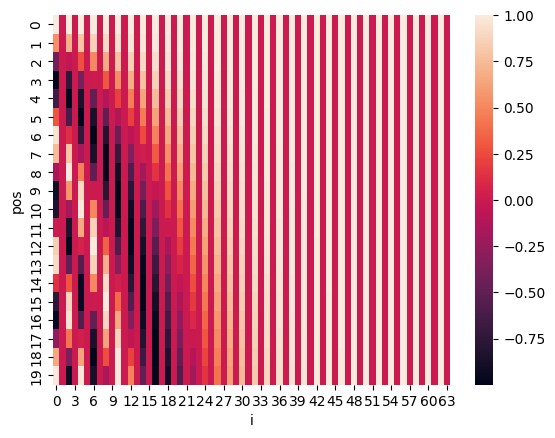

In [12]:
emb_dim = 64
max_seq_len = 100
seq_len = 20

pe = PositionalEncoding(emb_dim, 0, max_seq_len)
positional_encoding = pe(torch.zeros(1, seq_len, emb_dim, device=device))
plt.figure()
sns.heatmap(positional_encoding.squeeze().to('cpu'))
plt.xlabel('i')
plt.ylabel('pos')
plt.show()

(20, 8)


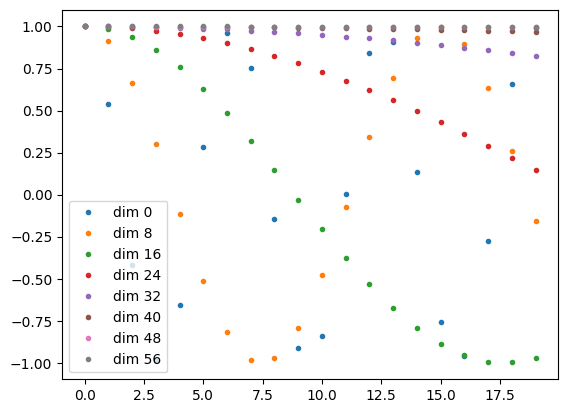

In [13]:
plt.figure()
y = positional_encoding.to("cpu").numpy()
print(y[0, :, 0 : 64 : 8].shape)
plt.plot(np.arange(seq_len), y[0, :, 0 : 64 : 8], ".")
plt.legend(["dim %d" % p for p in [0, 8, 16, 24, 32, 40, 48, 56]])
plt.show()

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        # SublayerConnection作用连接multi和ffn
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        # d_model
        self.size = size

    def forward(self, x, mask):
        # 将embedding层进行Multi head Attention
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # attn的结果直接作为下一层输入
        return self.sublayer[1](x, self.feed_forward)

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        # 复制N个编码器基本单元
        self.layers = clones(layer, N)
        # 层归一化
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        循环编码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        """
        循环解码器基本单元N次
        """
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
        
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.attn(x, m, m, src_mask))

        return self.sublayer[2](x, self.feed_forward)

In [15]:
class Generator(nn.Module):
    """
    解码器输出经线性变换和softmax函数映射为下一时刻预测单词的概率分布
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        # decode后的结果，先进入一个全连接层变为词典大小的向量
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        # 然后再进行log_softmax操作(在softmax结果上再做多一次log运算)
        return F.log_softmax(self.proj(x), dim=-1)
    

In [16]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
    def encode(self, src, src_mask):
        x = self.encoder(self.src_embed(src), src_mask)
        return x
    def decode(self, memory, src_mask, tgt, tgt_mask):
        x = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return x
    def forward(self, src, tgt, src_mask, tgt_mask):
        x = self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
        return x

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


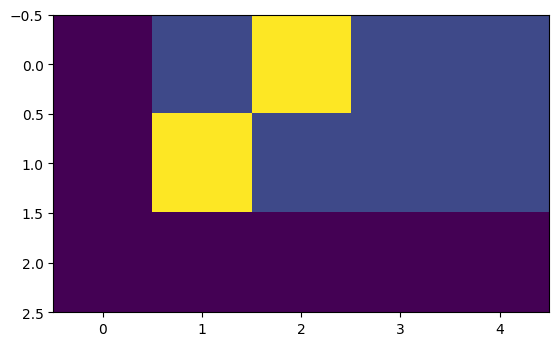

In [17]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model).to(device)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout).to(device)
    position = PositionalEncoding(d_model, dropout).to(device)
    model = Transformer(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout).to(device), N).to(device),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout).to(device), N).to(device),
        nn.Sequential(Embeddings(d_model, src_vocab).to(device), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab).to(device), c(position)),
        Generator(d_model, tgt_vocab)
    ).to(device)
    
    for p in model.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)
    return model.to(device)

class LabelSmoothing(nn.Module):
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1.0-smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1)==self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing/(self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data==self.padding_idx)
        if mask.dim()>0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
    
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()),
         Variable(torch.LongTensor([2, 1, 0])))
print(crit.true_dist)
plt.imshow(crit.true_dist)

In [18]:
class SimpleLossCompute:
    """
    简单的计算损失和进行参数反向传播更新训练的函数
    """

    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data.item() * norm.float()

In [19]:
class NoamOpt:
    "Optim wrapper that implements rate."

    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


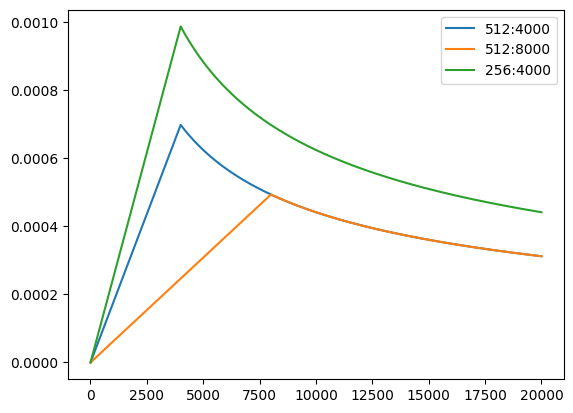

In [20]:
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
                   torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None),
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])


In [24]:
from tqdm import tqdm, trange
def run_epoch(data, model, loss_compute, epoch):
    start = time.time()
    total_tokens = 0.
    total_loss = 0.
    tokens = 0.

    for i, batch in enumerate(data):
        out = model(batch.src, batch.trg, batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch %d Batch: %d Loss: %f Tokens per Sec: %fs" % (
            epoch, i - 1, loss / batch.ntokens, (tokens.float() / elapsed / 1000.)))
            start = time.time()
            tokens = 0

    return total_loss / total_tokens


In [ ]:
def train(data, model, criterion, optimizer):
    """
    训练并保存模型
    """
    # 初始化模型在dev集上的最优Loss为一个较大值
    best_dev_loss = 1e5

    for epoch in trange(epochs):
        # 模型训练
        model.train()
        run_epoch(data.train_data, model, SimpleLossCompute(model.generator, criterion, optimizer), epoch)
        model.eval()

        # 在dev集上进行loss评估
        print('>>>>> Evaluate')
        dev_loss = run_epoch(data.dev_data, model, SimpleLossCompute(model.generator, criterion, None), epoch)
        print('<<<<< Evaluate loss: %f' % dev_loss)

        # 如果当前epoch的模型在dev集上的loss优于之前记录的最优loss则保存当前模型，并更新最优loss值
        if not os.path.exists(save_path):
            os.mkdir('./save')
        if dev_loss < best_dev_loss:
            torch.save(model.state_dict(), save_path)
            best_dev_loss = dev_loss
            print('****** Save model done... ******')

        print()


# 数据预处理
data = PrepareData(TRAIN_FILE, DEV_FILE)
src_vocab = len(data.en_word_dict)
tgt_vocab = len(data.cn_word_dict)
print("src_vocab %d" % src_vocab)
print("tgt_vocab %d" % tgt_vocab)

# 初始化模型
model = make_model(
                    src_vocab,
                    tgt_vocab,
                    layers,
                    d_model,
                    d_ff,
                    h_num,
                    dropout
                )

# 训练
print(">>>>>>> start train")
train_start = time.time()
criterion = LabelSmoothing(tgt_vocab, padding_idx = 0, smoothing= 0.0)
optimizer = NoamOpt(d_model, 1, 2000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9,0.98), eps=1e-9))

train(data, model, criterion, optimizer)
print(f"<<<<<<< finished train, cost {time.time()-train_start:.4f} seconds")


src_vocab 5493
tgt_vocab 2537
>>>>>>> start train


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Batch: 0 Loss: 7.842962 Tokens per Sec: 23.288563s
Epoch 0 Batch: 50 Loss: 6.858658 Tokens per Sec: 25.555380s
Epoch 0 Batch: 100 Loss: 6.148924 Tokens per Sec: 25.714836s
>>>>> Evaluate
Epoch 0 Batch: 0 Loss: 5.411907 Tokens per Sec: 30.533617s
<<<<< Evaluate loss: 5.812776


  5%|▌         | 1/20 [00:07<02:16,  7.16s/it]

****** Save model done... ******

Epoch 1 Batch: 0 Loss: 5.858931 Tokens per Sec: 23.326242s
Epoch 1 Batch: 50 Loss: 5.363670 Tokens per Sec: 25.160553s
Epoch 1 Batch: 100 Loss: 5.024110 Tokens per Sec: 21.403990s
>>>>> Evaluate
Epoch 1 Batch: 0 Loss: 4.399774 Tokens per Sec: 30.965349s
<<<<< Evaluate loss: 4.927863


 10%|█         | 2/20 [00:14<02:15,  7.54s/it]

****** Save model done... ******

Epoch 2 Batch: 0 Loss: 4.939448 Tokens per Sec: 22.840836s
Epoch 2 Batch: 50 Loss: 4.703244 Tokens per Sec: 24.939377s
Epoch 2 Batch: 100 Loss: 4.409102 Tokens per Sec: 23.156397s
>>>>> Evaluate
Epoch 2 Batch: 0 Loss: 3.770160 Tokens per Sec: 32.692760s
<<<<< Evaluate loss: 4.297311


 15%|█▌        | 3/20 [00:22<02:08,  7.56s/it]

****** Save model done... ******

Epoch 3 Batch: 0 Loss: 4.479764 Tokens per Sec: 23.211985s
Epoch 3 Batch: 50 Loss: 4.174612 Tokens per Sec: 24.286530s
Epoch 3 Batch: 100 Loss: 3.890013 Tokens per Sec: 24.050226s
>>>>> Evaluate
Epoch 3 Batch: 0 Loss: 3.255098 Tokens per Sec: 31.283535s
<<<<< Evaluate loss: 3.771543


 20%|██        | 4/20 [00:30<02:00,  7.55s/it]

****** Save model done... ******

Epoch 4 Batch: 0 Loss: 3.974175 Tokens per Sec: 23.145432s
Epoch 4 Batch: 50 Loss: 3.729547 Tokens per Sec: 24.711458s
Epoch 4 Batch: 100 Loss: 3.417558 Tokens per Sec: 24.013779s
>>>>> Evaluate
Epoch 4 Batch: 0 Loss: 2.776688 Tokens per Sec: 27.546043s
<<<<< Evaluate loss: 3.342062


 25%|██▌       | 5/20 [00:37<01:53,  7.54s/it]

****** Save model done... ******

Epoch 5 Batch: 0 Loss: 3.605324 Tokens per Sec: 22.232729s
Epoch 5 Batch: 50 Loss: 3.326755 Tokens per Sec: 24.592123s
Epoch 5 Batch: 100 Loss: 3.100396 Tokens per Sec: 23.701141s
>>>>> Evaluate
Epoch 5 Batch: 0 Loss: 2.416098 Tokens per Sec: 29.245064s
<<<<< Evaluate loss: 2.968869


 30%|███       | 6/20 [00:45<01:45,  7.52s/it]

****** Save model done... ******

Epoch 6 Batch: 0 Loss: 3.310965 Tokens per Sec: 21.428083s
Epoch 6 Batch: 50 Loss: 3.011942 Tokens per Sec: 24.458841s
